# 頭部姿態(Head pose)估計使用OpenCV和dlib

我們將學習如何使用OpenCV和Dlib來估計照片中人體頭部的姿態。

在許多應用中，我們需要知道頭部相對於相機(camera)的傾斜情況。例如，可以使用頭部的姿勢來渲染場景的正確視圖。在駕駛員輔助系統中，在車輛中查看駕駛員的臉部的相機可以使用頭部姿勢估計來查看駕駛員是否正在關注道路。當然，可以使用基於頭部姿勢的手勢來控制一些應用程程或遊戲。

![head-pose](https://user-images.githubusercontent.com/13165885/35322960-f79bfe98-0126-11e8-8064-a229c577be5e.png)

## 什麼是頭部姿態估計?

在計算機視覺中，物體的姿態(the pose of an object)是指其相對於相機的相對方向和位置。我們可以通過將物體相對於相機或相機相對於物體的移動來更改姿態。

姿態估計問題在計算機視覺中通常被稱為透視n點問題或PNP。這個問題中，目標是當我們有一個校準過的相機而且我們知道物體上n個3D點的位置以及相應的2D投影圖像時要去估測一個物體的姿態(pose)。

![3d](https://pic.pimg.tw/silverwind1982/1477645318-475283011.png)

## 如何使用數學表示相機的運動?

3D物體只有兩種相對於相機的運動。

* 平移(Translation)：將相機從當前的3D位置（X，Y，Z）移動到新的3D位置（X'，Y'，Z'）稱為平移。正如你所看到的，平移有3個自由度 - 你可以在X，Y或Z方向移動。平移由（X' -  X，Y' -  Y，Z' -  Z）的vector來表示。

* 旋轉(Rotation)：你可以圍繞X，Y和Z軸旋轉照像機。因此，旋轉也有三個自由度。有很多方法來表示旋轉。您可以使用歐拉角（滾動，俯仰和偏航），3 x 3旋轉矩陣或旋轉方向（即軸）和角度來表示它。

所以，估計3D物體的姿態意味著找到__6__個數字 - 三個用於平移，三個用於旋轉。

##  做姿態估計時你需要什麼?

![head-pose](https://www.learnopencv.com/wp-content/uploads/2016/09/pose-estimation-requirements-opencv.jpg)

要計算圖像中物體的三維姿態，您需要以下信息:
1. 幾點的2D坐標：我們需要圖像中幾個點的二維（x，y）位置。在臉部的情況下，我們可以選擇眼角，鼻尖，嘴角等。Dlib的臉部特徵檢測器為我們提供了許多可供選擇的點。我們將使用鼻尖，下巴，左眼的左上角，右眼的右上角，嘴的左上角和嘴的右上角。

2. 相同2D點的3D坐標：我們還需要2D特徵點的3D位置。你可能會想，你需要照片中人物的3D模型來獲取3D位置。理想情況是這樣沒錯，但在實務中，要從一個2D圖像去產生3D的模型需要其它深度學習的演算法。在這裡我們將使用一個通用的3D模型就足夠了。我們從哪裡得到一個3D頭部模型呢?其實我們不需要一個完整的3D模型。我們只需要在某個任意人臉3D模型中找需要點的3D座標。在本教程中，我們將使用以下3D座標:
    * 鼻尖(Tip of the nose): ( 0.0, 0.0, 0.0)
    * 下巴(Chin): ( 0.0, -330.0, -65.0)
    * 左眼左角(Left corner of the left eye):  (-225.0f, 170.0f, -135.0)
    * 右眼右角(Right corner of the right eye): ( 225.0, 170.0, -135.0)
    * 嘴巴左角(Left corner of the mouth): (-150.0, -150.0, -125.0)
    * 嘴巴右角(Right corner of the mouth):  (150.0, -150.0, -125.0)
    
    請注意，我們以某個點為中心(例如:鼻尖)然後其的的點圍參考這個點來定義坐標。這樣定義的方式被稱為__世界坐標__（也稱為OpenCV文檔中的__模型坐標__）。

3. 相機的內在參數。如前所述，在這個問題中，相機被認為是校準的。換句話說，我們需要了解相機的焦距，圖像的光學中心以及徑向失真(distortion)等三個參數。當然，對於我們這些懶惰的工程師來說，這實在是太多的工作。透過不使用精確的3D模型，我們已經開始使用一些模擬估算的手法。所以我們可以通過圖像的中心來估算光學中心，通過像素的寬度來估算焦距並假定不存在徑向失真(沒有魚眼啦!)。

唬! 好暈~!

## 姿態估計演算法

有幾種演算法用於姿態估計。這裡有三個坐標系。上面顯示的各種面部特徵的三維坐標都在世界坐標中。如果我們知道旋轉和平移（即姿態），我們可以將世界坐標中的3D點轉換為相機坐標中的3D點。可以使用相機的固有參數（焦距，光學中心等）將相機坐標中的3D點投影到像平面（即圖像坐標系）上。

![pose-estimation-aligorithm](https://docs.opencv.org/3.1.0/pnp.jpg)

![camera space](https://i-msdn.sec.s-msft.com/dynimg/IC584329.png)

## OpenCV solvePnP函數


在OpenCV中，函數solvePnP可用於估計姿態。因此我們將採取以下步驟來進行:
* 步驟1：定位圖像中的臉部邊界框。
* 步驟2：檢測臉部的關鍵臉部結構並擷取需要的6個關鍵點。
* 步驟3：使用SolvePnP函數來估算臉部姿態。

### 需求

- [Python 3.5](https://www.python.org/)
- [Anaconda](https://anaconda.org/)
- [Pillow](https://opencv.org/)
- [dlib](http://blog.dlib.net/)
- [OpenCV](https://opencv.org/)

### 安裝
dlib在Windows的安裝不是非常容易, 經過多方試驗之後, 我發現最容易的方法還是透過Anaconda。
強烈建議使用Windows的朋友使用Anandoa。如果有安裝問題的朋友可能得上網找尋相關的症狀來解決。

1. 安裝Anaconda
2. 產生一個Anaconda環境
3. 安裝函式庫:
    
```
conda install -c conda-forge matplotlib 
conda install -c anaconda pillow
conda install -c conda-forge dlib
conda install -c conda-forge opencv
```

### 下載測試用圖像
1. 下載 [donald_trump圖像](http://www.abc.net.au/news/image/8356018-3x2-940x627.jpg) 到'data/'的子目錄中並命名為`donald_trump.jpg`。

### 下載檢測模型檔
1. 下載 [dlib 臉部關鍵點偵測模型](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2), 並解壓縮到'model/'的子目錄中

### 專案的檔案路徑佈局
   
你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
head-pose-estimation/
├── xxxx.ipynb
├── model/
│   └── shape_predictor_68_face_landmarks.dat
└── data/
    └── donald_trump.jpg

```

### 載入相關函式庫

In [1]:
# 把一些警告的訊息暫時関掉
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import os
import numpy as np
import math

# 圖像處理/展現的相關函式庫
import cv2
import dlib
import matplotlib.pyplot as plt

### 設定相關設定與參數

In [4]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# Face landmarks 的模型
SHAPE_MODEL_PATH = os.path.join(MODEL_PATH, "shape_predictor_68_face_landmarks.dat")

# 測試用圖像
TEST_IMAGE = os.path.join(DATA_PATH, "demo.jpg")

## 步驟1：定位圖像中的臉部邊界框

In [5]:
# 使用dlib自帶的frontal_face_detector作為我們的人臉偵測器
face_detector = dlib.get_frontal_face_detector()

# 載入圖像檔
img = cv2.imread(TEST_IMAGE);
size = img.shape

In [6]:
# 使用檢測器進行人臉檢測dets為返回的結果
# 第二個參數中的1表示把原始圖像變大，讓演算法能夠發現更多的人臉。
dets = face_detector(img, 1) 

# dets的元素個數即為偵測到臉的個數
print("Number of faces detected: {}".format(len(dets)))

Number of faces detected: 1


## 步驟2：檢測臉部關鍵臉部結構

In [7]:
print('Loading feature extraction model')
face_shape_model_path = SHAPE_MODEL_PATH
# 載入dlib的人臉landmarks偵測器
face_landmark_predictor = dlib.shape_predictor(face_shape_model_path) 

Loading feature extraction model


### 了解dlib的臉部關鍵點檢測器

dlib函式庫中的預先訓練好的臉部關鍵點檢測器可以用來估計映射到面部上的68個臉部關鍵點（x，y）坐標的位置。

我們可以在下面的圖片中看到68個坐標的索引值：

![facial-lanmark-index](https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_68markup-768x619.jpg)

在頭部姿態估算中,我們只需要其中的6個點座標:
* 鼻尖(Tip of the nose): 編號 __34__
* 下巴(Chin): 編號 __9__
* 左眼左角(Left corner of the left eye):  編號 __37__
* 右眼右角(Right corner of the right eye): 編號 __46__
* 嘴巴左角(Left corner of the mouth): 編號 __49__
* 嘴巴右角(Right corner of the mouth):  編號 __55__

In [8]:
# 將dlib偵測到的人臉68個特徵點取出
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

# 偵測單一人臉的臉部特徵(假設圖像中只有一個人)
def get_landmarks(im, face_detector, shape_predictor):
    rects = face_detector(im, 1)
    shape = shape_predictor(im, rects[0])
    coords = shape_to_np(shape, dtype="int")
        
    return coords

In [9]:
# 取得單1人臉的68個人臉關鍵點的座標
landmarks = get_landmarks(img, face_detector, face_landmark_predictor)

# 鼻尖 Nose tip: 34
nose_tip = landmarks[33:34]

# 下巴 Chin: 9
chin = landmarks[8:9]

# 左眼左角 Left eye left corner: 37
left_eye_corner = landmarks[36:37]

# 右眼右角 Right eye right corner: 46
right_eye_corner = landmarks[45:46]

# 嘴巴左角 Left Mouth corner: 49
left_mouth_corner = landmarks[48:49]

# 嘴巴右角 Right Mouth corner: 55
right_mouth_corner = landmarks[54:55]

# 把相關的6個座標串接起來
face_points = np.concatenate((nose_tip, chin, left_eye_corner, right_eye_corner, left_mouth_corner, right_mouth_corner))
face_points = face_points.astype(np.double)

print(face_points.shape)
print(face_points.dtype)

(6, 2)
float64


## 步驟3：估算頭部姿態

使用OpenCV的solvePnP函數來計算人臉的旋轉與位移。

In [10]:
# 3維模型的座標點 (使用一般的3D人臉模型的座標點)
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])

In [11]:
# 焦距
focal_length = size[1] 
print("Cameria [focal_length]: ", focal_length)

# 照像機內部成像的中心點(w, h)
center = (size[1]/2, size[0]/2)

# 照像機參數 (Camera internals )
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print("Camera Matrix :\n {0}".format(camera_matrix))


# 扭曲係數
dist_coeffs = np.zeros((4,1)) # 假設沒有鏡頭的成像扭曲 (no lens distortion)

# 使用OpenCV的solvePnP函數來計算人臉的旋轉與位移
#(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix
#                                                              , dist_coeffs, flags=cv2.CV_ITERATIVE)
# 參數:
#   model_points 3維模型的座標點
#   image_points 2維圖像的座標點
#   camera_matrix 照像機矩陣
#   dist_coeffs 照像機扭曲係數
#   flags: cv2.SOLVEPNP_ITERATIVE
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix
                                                              , dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

print("Rotation Vector:\n {0}".format(rotation_vector)) # 旋轉向量
print("Translation Vector:\n {0}".format(translation_vector)) # 位移向量

Cameria [focal_length]:  640
Camera Matrix :
 [[ 640.    0.  320.]
 [   0.  640.  200.]
 [   0.    0.    1.]]
Rotation Vector:
 [[-0.12794744]
 [ 3.27157313]
 [-0.41345239]]
Translation Vector:
 [[  244.82440188]
 [   -8.48133243]
 [-2740.9241835 ]]


### 計算歐拉角

詳細定義: [wikipedia](https://zh.wikipedia.org/wiki/%E6%AC%A7%E6%8B%89%E8%A7%92)

In [12]:
# 計算歐拉角
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6]

yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]

if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

抬頭(+)/低頭(-) [pitch]:  [ 14.13003347]
右轉(+)/左轉(-) [yaw]  :  [-9.5618414]
右傾(+)/左傾(-) [roll] :  [ 176.70851692]


### 視覺化

以鼻尖為原點來畫一個三軸以便視覺化看到頭部姿態的角度。

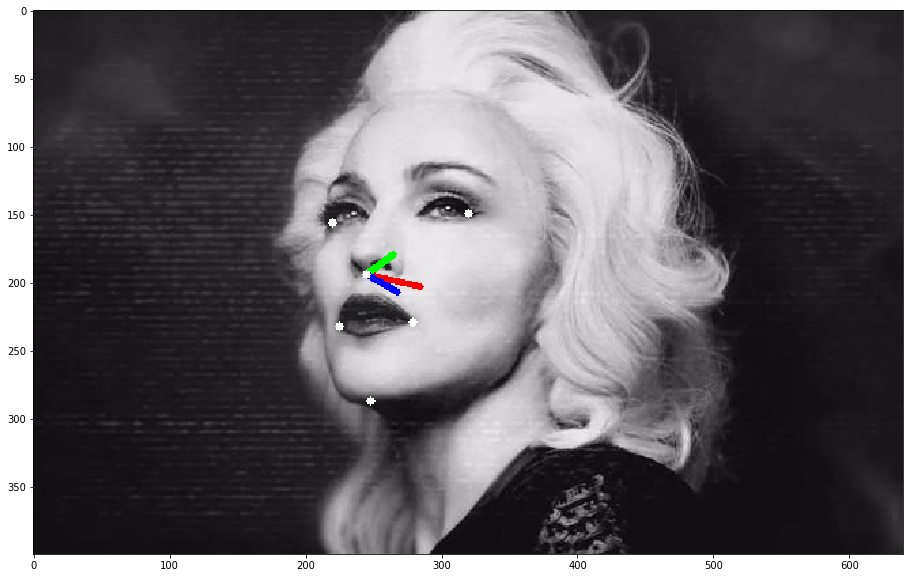

抬頭(+)/低頭(-) [pitch]:  [ 14.13003347]
右轉(+)/左轉(-) [yaw]  :  [-9.5618414]
右傾(+)/左傾(-) [roll] :  [ 176.70851692]


In [13]:
# 投射一個3D的點 (100.0, 0, 0)到2D圖像的座標上
(x_end_point2D, jacobian) = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 100.0, 0)到2D圖像的座標上
(y_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 0, 100.0)到2D圖像的座標上
(z_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector
                                           , translation_vector, camera_matrix, dist_coeffs)


# 以 Nose tip為中心點畫出x, y, z的軸線
p_nose = (int(face_points[0][0]), int(face_points[0][1]))

p_x = (int(x_end_point2D[0][0][0]), int(x_end_point2D[0][0][1]))

p_y = (int(y_end_point2D[0][0][0]), int(y_end_point2D[0][0][1]))

p_z = (int(z_end_point2D[0][0][0]), int(z_end_point2D[0][0][1]))

cv2.line(img, p_nose, p_x, (0,0,255), 3)  # X軸 (紅色)
cv2.line(img, p_nose, p_y, (0,255,0), 3)  # Y軸 (綠色)
cv2.line(img, p_nose, p_z, (255,0,0), 3)  # Z軸 (藍色)

# 把6個基準點標註出來
for p in face_points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (255,255,255), -1)

# 秀出圖像
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,::-1]) # 從BGR -> RGB
plt.show()

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

歐拉角的單位為"度"，數值範圍從-180度到+180度。

![head_pose](https://user-images.githubusercontent.com/13165885/35322960-f79bfe98-0126-11e8-8064-a229c577be5e.png)

### 參考:
* [Head Pose Estimation using OpenCV and Dlib](https://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/)
* [三維旋轉表示法 - 歐拉角、旋轉矩陣、旋轉向量、四元數](http://silverwind1982.pixnet.net/blog/post/258069682-%E4%B8%89%E7%B6%AD%E6%97%8B%E8%BD%89%E8%A1%A8%E7%A4%BA%E6%B3%95---%E6%AD%90%E6%8B%89%E8%A7%92%E3%80%81%E6%97%8B%E8%BD%89%E7%9F%A9%E9%99%A3%E3%80%81%E6%97%8B%E8%BD%89%E5%90%91)
* [Facial landmarks with dlib, OpenCV, and Python](https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/)
* [Face Tracking](https://msdn.microsoft.com/en-us/library/jj130970.aspx)
